In [1]:
%load_ext autoreload

In [3]:
%autoreload 2
import colorcet as cc
from hydra import compose, initialize
import matplotlib.pyplot as plt
import numpy as np
import os
from statsmodels.tsa.stattools import acf
import torch
import torchdiffeq

from UniversalUnconsciousness.plot_utils import load_font

plt.style.use('UniversalUnconsciousness.sci_style')
load_font()

In [4]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [5]:
img_save_dir = cfg.plotting.img_save_dir
curve_colors = cfg.plotting.curve_colors
loc_roc_colors = cfg.plotting.loc_roc_colors
os.makedirs(img_save_dir, exist_ok=True)

In [6]:


# Physical parameters
L = 1.0  # Length of pendulum (m)
g = 9.81  # Gravitational acceleration (m/s^2)
b = 0.5   # Damping coefficient (kg m/s)
m = 1.0   # Mass of bob (kg)
F = 0.0   # Magnitude of perturbation force (N)
t_start = 2.0  # Time when perturbation starts (s)
t_duration = 1.0  # Duration of perturbation (s)

# Define the system of first-order ODEs
time_pts = []
force = []
def pendulum_system(state, t, L, g, b, m, F, t_start, t_duration):
    theta, omega = state
    
    # Calculate the applied torque from the force perturbation
    # Force is applied horizontally to create a torque
    if t_start <= t <= (t_start + t_duration):
        torque = F * L
    else:
        torque = 0
    
    # Updated differential equations with perturbation torque
    dtheta = omega
    domega = -(g/L)*torch.sin(theta) - (b/(m*L))*omega + torque/(m*L)
    time_pts.append(t)
    force.append(torque)
    return torch.stack([dtheta, domega])

# Time points
t = torch.linspace(0, 3, 10000)

# Initial conditions: [theta_0, omega_0]
# Starting at rest (vertical position)
initial_state = torch.tensor([torch.pi/2, 0], dtype=torch.float32)

# # Solve the ODE system with new parameters
# solution = odeint(pendulum_system, initial_state, t, 
#                  args=(L, g, b, m, F, t_start, t_duration))
b = 2
solution_damped = torchdiffeq.odeint(lambda _t, y: pendulum_system(y, _t, L, g, b, m, F, t_start, t_duration), initial_state, t, 
                             method='rk4')
b = 0.02
solution_undamped = torchdiffeq.odeint(lambda _t, y: pendulum_system(y, _t, L, g, b, m, F, t_start, t_duration), initial_state, t, 
                             method='rk4')

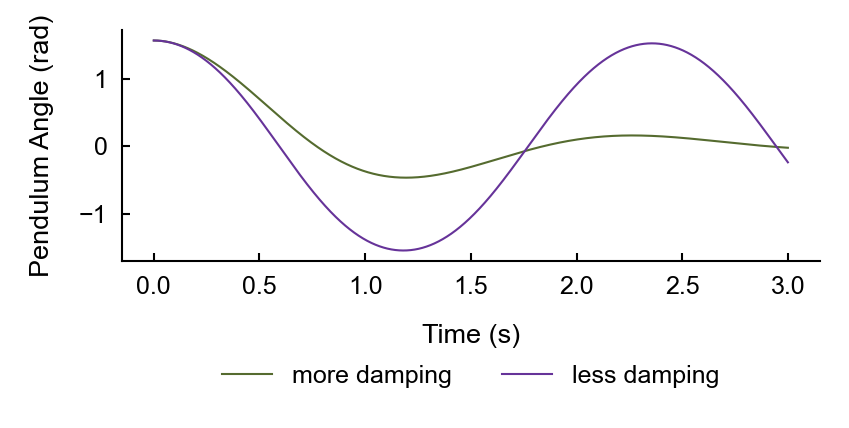

In [7]:
import scipy.signal as signal
# Plot the results
plt.figure(figsize=(3, 1))
plt.plot(t, solution_damped[:, 0], '-', label='more damping', c='darkolivegreen')
plt.plot(t, solution_undamped[:, 0], '-', label='less damping', color='rebeccapurple')

# # Find the first local maximum for the damped solution
# damped_local_max_indices = signal.argrelextrema(solution_damped[:, 0].cpu().numpy(), np.greater)[0]
# if len(damped_local_max_indices) > 0:
#     damped_max_time = t[damped_local_max_indices[0]].item()
#     plt.axvline(damped_max_time, linestyle=':', color='darkolivegreen', label='damped local max')

# # Find the first local maximum for the undamped solution
# undamped_local_max_indices = np.argmax(solution_undamped[2000:, 0].cpu().numpy())
# undamped_max_time = t[undamped_local_max_indices + 2000].item()
# plt.axvline(undamped_max_time, linestyle=':', color='rebeccapurple', label='undamped local max')

plt.xlabel('Time (s)')
plt.ylabel('Pendulum Angle (rad)')
plt.grid(False)
plt.legend(fontsize=6, loc='center', bbox_to_anchor=(0.5, -0.5), ncol=2)
plt.savefig(os.path.join(img_save_dir, 'pendulum-swing-timeseries.pdf'), transparent=True, bbox_inches='tight')
plt.show()

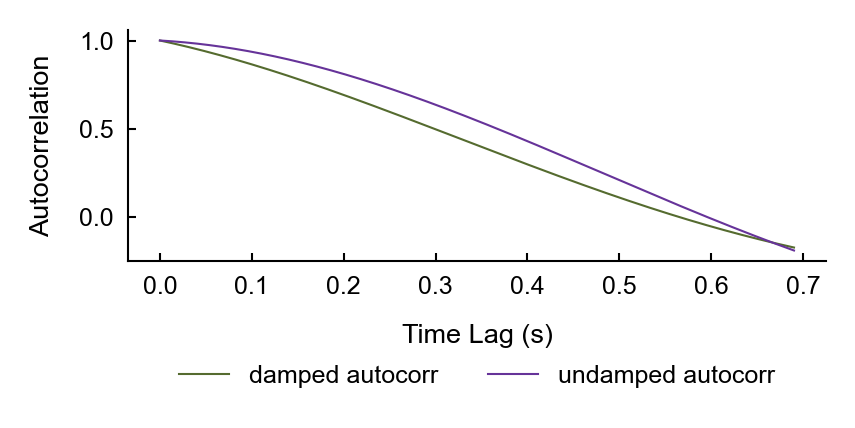

In [15]:
import scipy.signal as signal

# Plot the autocorrelation of the pendulum angles
plt.figure(figsize=(3, 1))

# Calculate and plot autocorrelation for the damped solution
# autocorr_damped = np.correlate(solution_damped[:, 0].cpu().numpy(), solution_damped[:, 0].cpu().numpy(), mode='full')
# autocorr_damped = autocorr_damped[autocorr_damped.size // 2:]
autocorr_damped = acf(solution_damped[:, 0].cpu().numpy(), nlags=2300)
plt.plot(np.arange(len(autocorr_damped))*t[1].cpu().numpy(), autocorr_damped, '-', label='damped autocorr', c='darkolivegreen')

# Calculate and plot autocorrelation for the undamped solution
# autocorr_undamped = np.correlate(solution_undamped[:, 0].cpu().numpy(), solution_undamped[:, 0].cpu().numpy(), mode='full')
# autocorr_undamped = autocorr_undamped[autocorr_undamped.size // 2:]
autocorr_undamped = acf(solution_undamped[:, 0].cpu().numpy(), nlags=2300)
plt.plot(np.arange(len(autocorr_undamped))*t[1].cpu().numpy(), autocorr_undamped, '-', label='undamped autocorr', color='rebeccapurple')

plt.xlabel('Time Lag (s)')
plt.ylabel('Autocorrelation')
plt.grid(False)
plt.legend(fontsize=6, loc='center', bbox_to_anchor=(0.5, -0.5), ncol=2)
plt.savefig(os.path.join(img_save_dir, 'pendulum-swing-autocorrelation.pdf'), transparent=True, bbox_inches='tight')
plt.show()

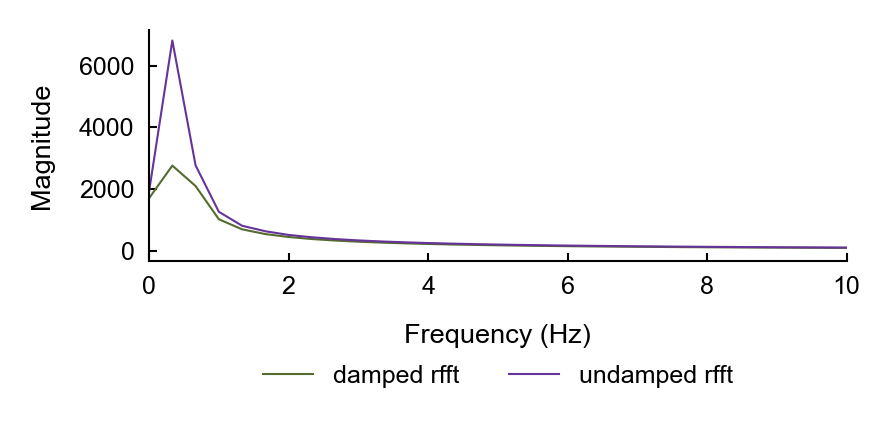

In [43]:
import numpy as np

# Plot the rfft of the pendulum angles
plt.figure(figsize=(3, 1))

# Calculate and plot rfft for the damped solution
rfft_damped = np.fft.rfft(solution_damped[:, 0].cpu().numpy())
freqs_damped = np.fft.rfftfreq(len(solution_damped[:, 0]), d=(t[1] - t[0]).item())
plt.plot(freqs_damped, np.abs(rfft_damped), '-', label='damped rfft', c='darkolivegreen')

# Calculate and plot rfft for the undamped solution
rfft_undamped = np.fft.rfft(solution_undamped[:, 0].cpu().numpy())
freqs_undamped = np.fft.rfftfreq(len(solution_undamped[:, 0]), d=(t[1] - t[0]).item())
plt.plot(freqs_undamped, np.abs(rfft_undamped), '-', label='undamped rfft', color='rebeccapurple')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(False)
plt.legend(fontsize=6, loc='center', bbox_to_anchor=(0.5, -0.5), ncol=2)
plt.xlim([0, 10])
plt.show()

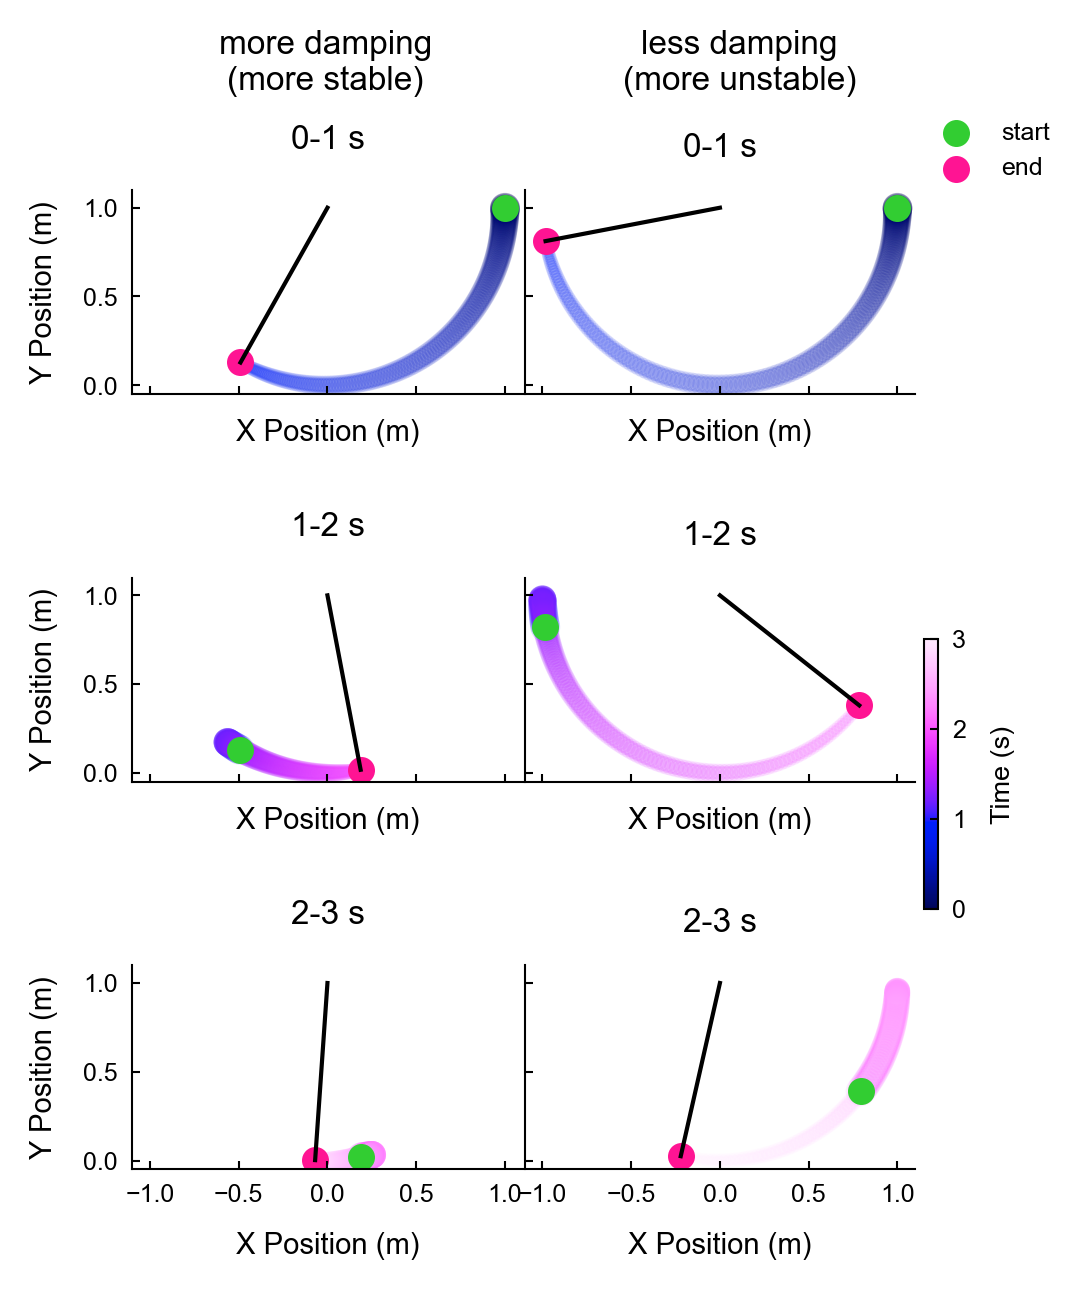

In [61]:
max_size = 38
min_size = 4

duration = 1.0  # seconds (each row covers 1 sec)
num_subplots = 3  # 3 rows

# Create a 3x2 grid. We use a slightly larger figure to avoid clipping text,
# but then use plt.subplots_adjust to force nearly zero whitespace.
fig, axes = plt.subplots(num_subplots, 2, figsize=(3,6), sharex=True, sharey=True)
# Adjust the subplots to provide a bit more space at the top to prevent clipping of the green circles.
fig.subplots_adjust(left=0.005, right=0.875, top=0.65, bottom=0.005, wspace=0.005, hspace=0.005)

# Add overall column titles (positioned with fig.text) as close to the plot area as possible.
fig.text(0.22, 0.67, 'more damping\n(more stable)', ha='center', va='center', fontsize=8)
fig.text(0.68, 0.67, 'less damping\n(more unstable)', ha='center', va='center', fontsize=8)

# Create a dedicated colorbar axes with minimal padding.
cbar_ax = fig.add_axes([0.885, 0.2, 0.015, 0.15])
norm = plt.Normalize(0, 3)
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('cet_bmw'), norm=norm)
sm.set_array([])

# Loop over each time block (row).
for i in range(num_subplots):
    current_start = i * duration
    current_end = (i + 1) * duration

    # Create a mask for the current time window.
    mask = (t >= current_start) & (t < current_end)
    
    # --- Damped trajectory (left column) ---
    theta_damped = solution_damped[:, 0].cpu().numpy()[mask]
    x_damped = L * np.sin(theta_damped)
    y_damped = -L * np.cos(theta_damped) + 1
    colors_damped = t.cpu().numpy()[mask]
    
    plot_every = 20
    x_damped = x_damped[::plot_every]
    y_damped = y_damped[::plot_every]
    colors_damped = colors_damped[::plot_every]
    
    ax_damped = axes[i, 0]
    ax_damped.scatter(
        x_damped, y_damped,
        c=colors_damped,
        cmap=plt.get_cmap('cet_bmw'),
        vmin=0, vmax=3,
        s=np.linspace(max_size, min_size, len(x_damped)),
        alpha=0.1
    )
    ax_damped.scatter(
        x_damped[0], y_damped[0],
        color='limegreen',
        s=30,
        label='start'
    )
    ax_damped.scatter(
        x_damped[-1], y_damped[-1],
        color='deeppink',
        s=30,
        label='end'
    )
    ax_damped.plot([0, x_damped[-1]], [1, y_damped[-1]], 'k-', lw=1)
    ax_damped.set_title(f'{current_start:.0f}-{current_end:.0f} s', fontsize=8, pad=10)
    ax_damped.set_xlabel('X Position (m)', fontsize=7)
    ax_damped.set_ylabel('Y Position (m)', fontsize=7)
    ax_damped.set_aspect('equal')
    ax_damped.tick_params(labelsize=6)
    ax_damped.set_ylim(top=1.1)  # Adjust y-limits to prevent clipping of the green circles
    
    # --- Undamped trajectory (right column) ---
    theta_undamped = solution_undamped[:, 0].cpu().numpy()[mask]
    x_undamped = L * np.sin(theta_undamped)
    y_undamped = -L * np.cos(theta_undamped) + 1
    colors_undamped = t.cpu().numpy()[mask]

    x_undamped = x_undamped[::plot_every]
    y_undamped = y_undamped[::plot_every]
    colors_undamped = colors_undamped[::plot_every]
    
    ax_undamped = axes[i, 1]
    ax_undamped.scatter(
        x_undamped, y_undamped,
        c=colors_undamped,
        cmap=plt.get_cmap('cet_bmw'),
        vmin=0, vmax=3,
        s=np.linspace(max_size, min_size, len(x_undamped)),
        alpha=0.1
    )
    ax_undamped.scatter(
        x_undamped[0], y_undamped[0],
        color='limegreen',
        s=30,
        label='start'
    )
    ax_undamped.scatter(
        x_undamped[-1], y_undamped[-1],
        color='deeppink',
        s=30,
        label='end'
    )
    ax_undamped.plot([0, x_undamped[-1]], [1, y_undamped[-1]], 'k-', lw=1)
    ax_undamped.set_title(f'{current_start:.0f}-{current_end:.0f} s', fontsize=8)
    ax_undamped.set_xlabel('X Position (m)', fontsize=7)
    ax_undamped.set_aspect('equal')
    ax_undamped.tick_params(labelsize=6)
    ax_undamped.set_ylim(top=1.1)  # Adjust y-limits to prevent clipping of the green circles

# Add the colorbar to the dedicated axes with no extra padding.
fig.colorbar(sm, cax=cbar_ax, label='Time (s)', pad=0)

# Add a legend for the start and end markers
handles, labels = ax_damped.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=6, bbox_to_anchor=(1.05, 0.65))

plt.savefig(os.path.join(img_save_dir, 'pendulum-swing.pdf'), transparent=True, bbox_inches='tight')
plt.show()

In [32]:
# # Plot Pendulum Trajectory with Time Progression

# import matplotlib.pyplot as plt
# import numpy as np

# max_size = 38
# min_size = 4

# # Enable constrained layout for automatic adjustment
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 2), sharey=True, constrained_layout=True)

# # Plot damped solution
# theta_damped = solution_damped[:, 0].cpu().numpy()
# x_damped = L * np.sin(theta_damped)
# y_damped = -L * np.cos(theta_damped) + 1
# colors = t.cpu().numpy()

# plot_every = 20
# # scatter1 = ax1.scatter(
# #     x_damped[::plot_every],
# #     y_damped[::plot_every],
# #     c=colors[::plot_every],
# #     cmap='viridis',
# #     s=38,
# #     label='Pendulum Path',
# #     alpha=0.5
# # )

# # Create a size array that decreases from 38 to 18
# num_points = len(x_damped[::plot_every])
# sizes = np.linspace(max_size, min_size, num_points)
# scatter1 = ax1.scatter(
#     x_damped[::plot_every],
#     y_damped[::plot_every],
#     c=colors[::plot_every],
#     cmap='viridis',
#     s=sizes,  # Apply the decreasing sizes
#     label='Pendulum Path',
#     alpha=0.5
# )

# ax1.scatter(x_damped[0], y_damped[0], color='green', label='Start', s=80)
# ax1.scatter(x_damped[-1], y_damped[-1], color='red', label='End', s=80)
# ax1.plot([0, x_damped[-1]], [1, y_damped[-1]], 'k-', lw=1)
# ax1.set_xlabel('X Position (m)')
# ax1.set_ylabel('Y Position (m)')
# ax1.set_title('Damped Pendulum Trajectory')
# # ax1.set_ylim([0, 1])

# # Plot undamped solution
# theta_undamped = solution_undamped[:, 0].cpu().numpy()
# x_undamped = L * np.sin(theta_undamped)
# y_undamped = -L * np.cos(theta_undamped) + 1

# # scatter2 = ax2.scatter(
# #     x_undamped[::plot_every],
# #     y_undamped[::plot_every],
# #     c=colors[::plot_every],
# #     cmap='viridis',
# #     s=38,
# #     label='Pendulum Path',
# #     alpha=0.5
# # )

# num_points = len(x_damped[::plot_every])
# sizes = np.linspace(max_size, min_size, num_points)
# scatter2 = ax2.scatter(
#     x_undamped[::plot_every],
#     y_undamped[::plot_every],
#     c=colors[::plot_every],
#     cmap='viridis',
#     s=sizes,  # Apply the decreasing sizes
#     label='Pendulum Path',
#     alpha=0.5
# )

# ax2.scatter(x_undamped[0], y_undamped[0], color='green', label='Start', s=80)
# ax2.scatter(x_undamped[-1], y_undamped[-1], color='red', label='End', s=80)
# ax2.plot([0, x_undamped[-1]], [1, y_undamped[-1]], 'k-', lw=1)
# ax2.set_xlabel('X Position (m)')
# ax2.set_title('Undamped Pendulum Trajectory')

# # Create a single legend below both plots
# handles, labels = ax1.get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))

# # Calculate combined limits
# all_x = np.concatenate([x_damped, x_undamped])
# all_y = np.concatenate([y_damped, y_undamped])

# x_min, x_max = all_x.min(), all_x.max()
# y_min, y_max = all_y.min(), all_y.max()

# # Add padding
# padding_x = (x_max - x_min) * 0.05
# padding_y = (y_max - y_min) * 0.08

# x_min -= padding_x
# x_max += padding_x
# y_min -= padding_y
# y_max += padding_y
# # ymax = 1

# # Set the same limits and aspect ratio for both axes
# for ax in [ax1, ax2]:
#     ax.set_xlim(x_min, x_max)
#     ax.set_ylim(y_min, y_max)
#     ax.set_aspect('equal')

# # Add a single colorbar for both scatter plots, aligned with the plots' height
# cbar = fig.colorbar(
#     scatter2,
#     ax=[ax1, ax2],
#     orientation='vertical',
#     fraction=0.02,
#     pad=0.04
# )
# cbar.set_label('Time (s)')

# plt.show()